In [1]:
%load_ext nb_black

import pandas as pd
import numpy as np
import math
from sklearn.feature_selection import chi2
import textstat

# for text pre-processing
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS

# text deep preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns

<IPython.core.display.Javascript object>

Data preprocessing -> Vectorization -> Latent Factor Analysis -> Similarity Measurement

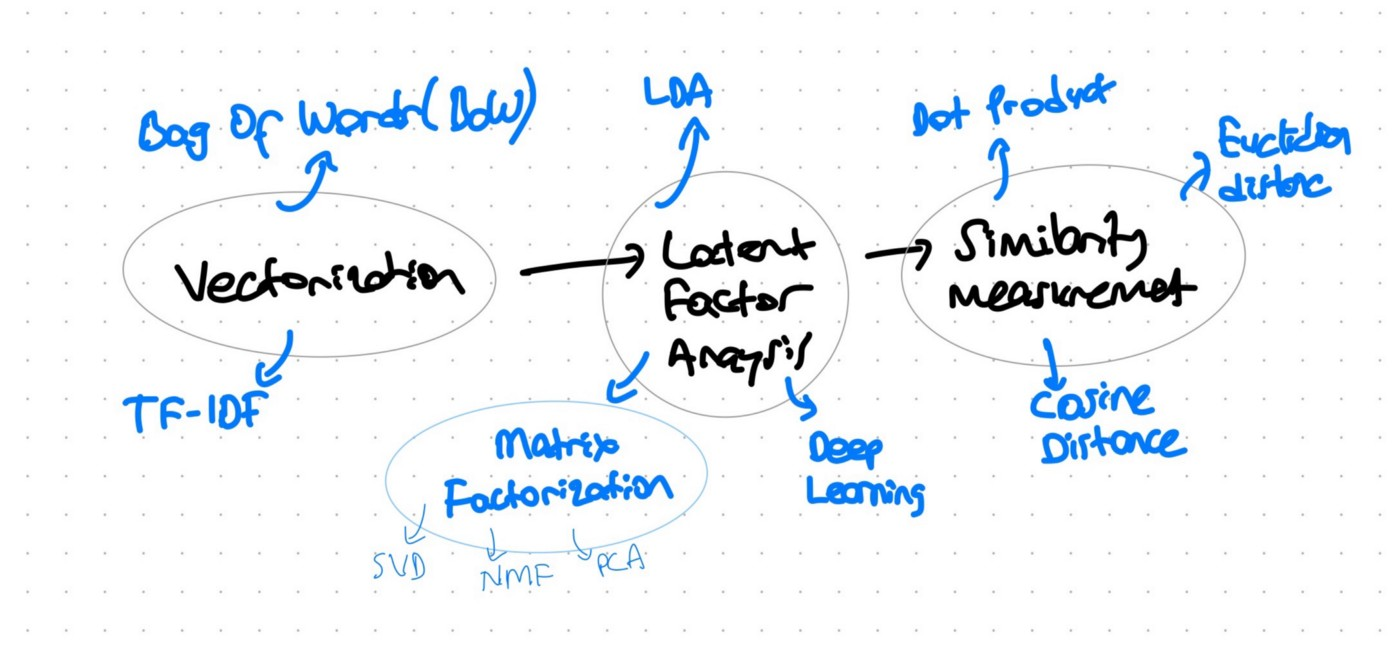

In [2]:
# nltk.download("stopwords")
# nltk.download("wordnet")
# nltk.download("punkt")

<IPython.core.display.Javascript object>

In [3]:
train = pd.read_csv("data/train.csv")

<IPython.core.display.Javascript object>

In [4]:
train["category_id"] = train["categories"].factorize()[0]

<IPython.core.display.Javascript object>

# Raw data - exploration

In [5]:
train.head()

ImgId                                              title  \
0  B000HYL1V6                   TUNGSTEN SOLDER PICK WITH HANDLE   
1  B00006HXWY  Write Right 98167 Screen Protector for Sony T615C   
2  B000GAWSBS  Casio Mens DBC310-1 Databank 300 Digital Watch...   
3  B000040JOL  Factory-Reconditioned DEWALT DW260KR Heavy-Dut...   
4  B00006IB78                             Energizer 2 in 1 Light   

                                         description  \
0  Solder Pick for picking up molten solder when ...   
1  We all screen. And we all need to protect thos...   
2  Bringing you precision at a glance, the Casio ...   
3  Factory-Reconditioned DEWALT DW260KR Heavy-Dut...   
4  This twoway light features a bright flashlight...   

                  categories  category_id  
0      Arts, Crafts & Sewing            0  
1  Cell Phones & Accessories            1  
2  Clothing, Shoes & Jewelry            2  
3   Tools & Home Improvement            3  
4     Health & Personal Care            4

<IPython.core.display.Javascript object>

In [6]:
print("Total number of products : ", train.shape[0])
print("Number of product categories:", train["categories"].nunique())

Total number of products :  46229
Number of product categories: 21


<IPython.core.display.Javascript object>

In [7]:
train["categories"].value_counts()

Arts, Crafts & Sewing        2225
Beauty                       2202
Grocery & Gourmet Food       2201
Sports & Outdoors            2201
Automotive                   2200
Industrial & Scientific      2200
Musical Instruments          2200
Appliances                   2200
Office Products              2200
All Beauty                   2200
Toys & Games                 2200
Electronics                  2200
All Electronics              2200
Cell Phones & Accessories    2200
Patio, Lawn & Garden         2200
Baby                         2200
Baby Products                2200
Health & Personal Care       2200
Tools & Home Improvement     2200
Clothing, Shoes & Jewelry    2200
Pet Supplies                 2200
Name: categories, dtype: int64

<IPython.core.display.Javascript object>

## Explore missing values

In [8]:
percent_missing = train.isnull().sum() / len(train)
missing_values = pd.DataFrame({"percent_missing": percent_missing})
missing_values.style.format({"percent_missing": "{:.2%}"})

<IPython.core.display.Javascript object>

In [9]:
percent_missing = (
    train["categories"][train["description"].isna()].value_counts()
) / train["categories"].value_counts()
missing_values = pd.DataFrame({"percent_missing": percent_missing})
missing_values.style.format({"percent_missing": "{:.2%}"})

<IPython.core.display.Javascript object>

In [10]:
# fill in missing values
train = train.fillna("")

<IPython.core.display.Javascript object>

## Explore length of title and description

In [11]:
train["title_len"] = train["title"].str.len()
train["desc_len"] = train["description"].str.len()
train["title_words"] = train["title"].str.split().str.len()
train["desc_words"] = train["description"].str.split().str.len()

<IPython.core.display.Javascript object>

<AxesSubplot:>

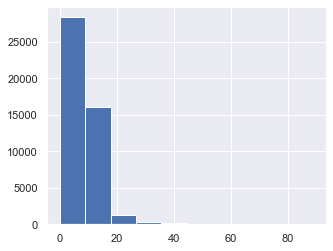

<IPython.core.display.Javascript object>

In [12]:
# plot title number of words
sns.set(rc={"figure.figsize": (5, 4)})
train["title_words"].hist()

<AxesSubplot:>

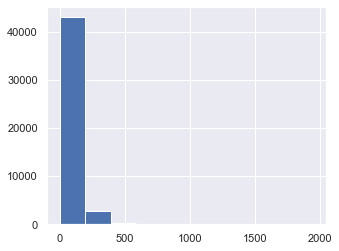

<IPython.core.display.Javascript object>

In [13]:
# plot description number of words
sns.set(rc={"figure.figsize": (5, 4)})
train["desc_words"].hist()

<AxesSubplot:xlabel='title_words', ylabel='categories'>

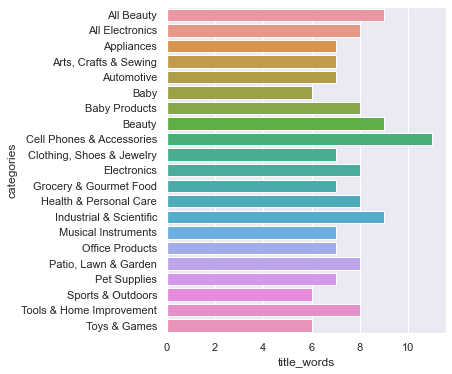

<IPython.core.display.Javascript object>

In [14]:
sns.set(rc={"figure.figsize": (5, 6)})
tplot = (
    train[["title_words", "categories"]].groupby("categories").median().reset_index()
)
sns.barplot(data=tplot, x="title_words", y="categories")

<AxesSubplot:xlabel='desc_words', ylabel='categories'>

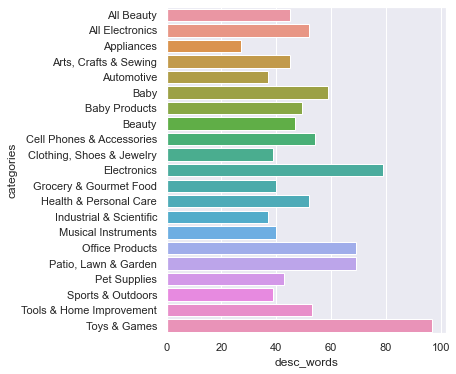

<IPython.core.display.Javascript object>

In [15]:
sns.set(rc={"figure.figsize": (5, 6)})
dplot = train[["desc_words", "categories"]].groupby("categories").median().reset_index()
sns.barplot(data=dplot, x="desc_words", y="categories")

<AxesSubplot:xlabel='title_words', ylabel='categories'>

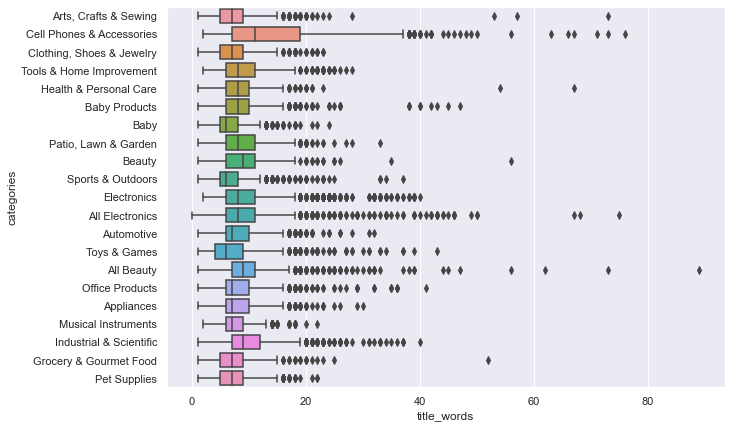

<IPython.core.display.Javascript object>

In [16]:
plt.figure(figsize=(10, 7))
sns.boxplot(y="categories", x="title_words", data=train, orient="h")

<AxesSubplot:xlabel='desc_words', ylabel='categories'>

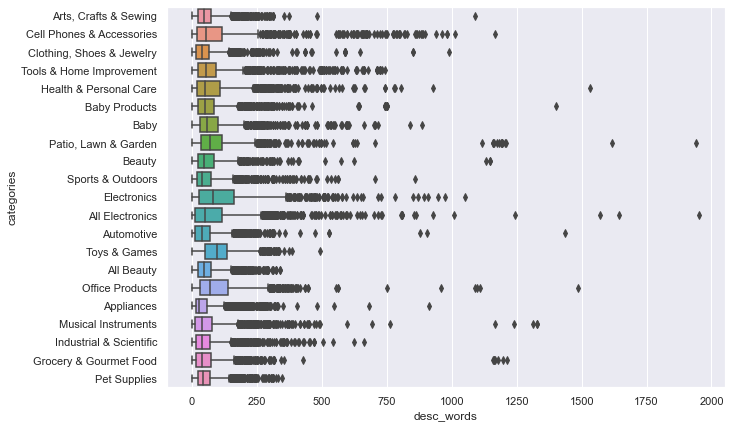

<IPython.core.display.Javascript object>

In [17]:
plt.figure(figsize=(10, 7))

sns.boxplot(y="categories", x="desc_words", data=train, orient="h")

## Word counts

In [18]:
def get_top_n_words(corpus, n=None, ngrams=1):
    corpus = corpus.fillna("")
    vec = CountVectorizer(ngram_range=(ngrams, ngrams)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

<IPython.core.display.Javascript object>

### Title

<AxesSubplot:xlabel='count', ylabel='word'>

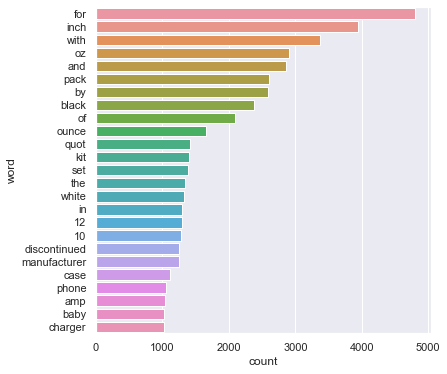

<IPython.core.display.Javascript object>

In [19]:
top_20_titles = get_top_n_words(train["title"], 25, 1)
top_20_titles = pd.DataFrame(top_20_titles, columns=["word", "count"])

plt.figure(figsize=(6, 6))
sns.barplot(data=top_20_titles, x="count", y="word")

<AxesSubplot:xlabel='count', ylabel='word'>

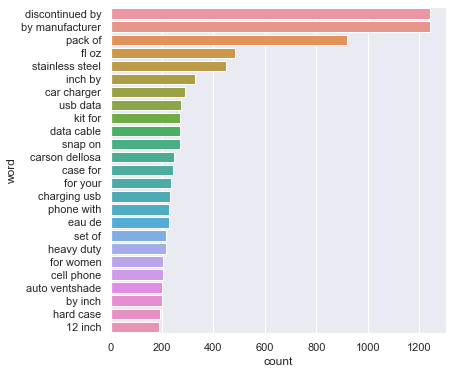

<IPython.core.display.Javascript object>

In [20]:
top_20_bi_titles = get_top_n_words(train["title"], 25, 2)
top_20_bi_titles = pd.DataFrame(top_20_bi_titles, columns=["word", "count"])

plt.figure(figsize=(6, 6))
sns.barplot(data=top_20_bi_titles, x="count", y="word")

### Description

<AxesSubplot:xlabel='count', ylabel='word'>

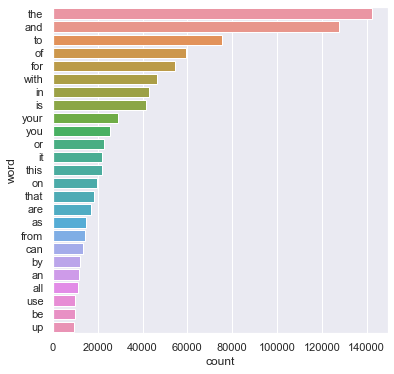

<IPython.core.display.Javascript object>

In [21]:
top_20_desc = get_top_n_words(train["description"], 25, 1)
top_20_desc = pd.DataFrame(top_20_desc, columns=["word", "count"])

plt.figure(figsize=(6, 6))
sns.barplot(data=top_20_desc, x="count", y="word")

<AxesSubplot:xlabel='count', ylabel='word'>

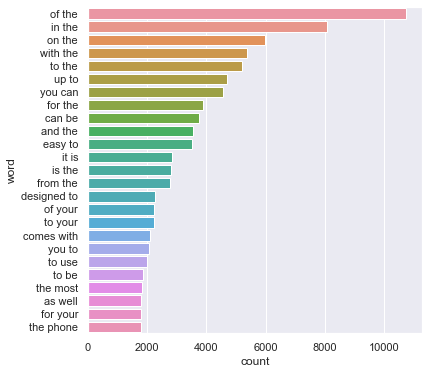

<IPython.core.display.Javascript object>

In [22]:
top_20_bi_desc = get_top_n_words(train["description"], 25, 2)
top_20_bi_desc = pd.DataFrame(top_20_bi_desc, columns=["word", "count"])

plt.figure(figsize=(6, 6))
sns.barplot(data=top_20_bi_desc, x="count", y="word")

## Readability of the description 
(although not relevant while tagging -  we want to use as many as possible tags that user might use)

* dale_chall_score ==> 0 (lowest grade) - 9.9 (highest grade / college) \
Different from other tests, since it uses a lookup table of the most commonly used 3000 English words. Thus it returns the grade level using the New Dale-Chall Formula.
* flesh_reading_ease ==> 0 (very difficult) - 100 (very easy) \
Flesch-Kincaid reading ease (red) and grade level (gray) scores against average syllables per word and average words per sentence
* gunning_fog ==> 6 (Sixth grade) - 17 (Graduate student)\
Another method that uses syllables and average sentence length
* text_standard ==>  Based other readability tests (eg. ones mentioned above), returns the estimated school grade level required to understand the text.
* reading_time ==> the less the better (the shorter the description the more informative / concise it is)

https://pypi.org/project/textstat/

In [23]:
def get_category_readability(data, var):
    categories = list(data["categories"].unique())
    methods = {
        "dale_chall_score": textstat.dale_chall_readability_score,
        "flesh_reading_ease": textstat.flesch_reading_ease,
        "gunning_fog": textstat.gunning_fog,
        "text_standard": textstat.text_standard,
        "reading_time": textstat.reading_time,
    }

    for key, value in methods.items():
        data[key] = data[var].apply(lambda x: value(x))

    readibility = {}

    for category in categories:
        readibility[category] = {}
        readibility[category]["dale_chall_score"] = data["dale_chall_score"][
            data["categories"] == category
        ].mean()

        readibility[category]["flesh_reading_ease"] = data["flesh_reading_ease"][
            data["categories"] == category
        ].mean()

        readibility[category]["gunning_fog"] = data["gunning_fog"][
            data["categories"] == category
        ].mean()
        readibility[category]["text_standard"] = data["text_standard"][
            data["categories"] == category
        ].mode()[0]
        readibility[category]["reading_time"] = data["reading_time"][
            data["categories"] == category
        ].mean()

    return readibility

<IPython.core.display.Javascript object>

In [24]:
readability_scores = get_category_readability(train, "description")

<IPython.core.display.Javascript object>

In [25]:
readability_scores_df = pd.DataFrame.from_dict(readability_scores, orient="index")

<IPython.core.display.Javascript object>

In [26]:
cm = sns.light_palette("green", as_cmap=True)

readability_scores_df.style.background_gradient(subset=['dale_chall_score'], cmap=cm.reversed())\
        .background_gradient(subset=['flesh_reading_ease'], cmap=cm,  vmin=40, vmax=100)\
        .background_gradient(subset=['gunning_fog'],  cmap=cm.reversed(), vmin=6, vmax=17)\
        .background_gradient(subset=['reading_time'], cmap=cm.reversed(), vmin=4, vmax=10)
#.style.format({'dale_chall_score': '{:.2%}'})\


<IPython.core.display.Javascript object>

Easiest to read descriptions are used in categories such as **Baby** and **Sports & Outdoors**. Those descriptions are also least complex and fastest to read (mainly due to their length). 

Most difficult to read descriptions, that use most sophisticated words are **Electronics** and **All electronics**.

# Normalised data - exploration

## Text preprocessing

In [27]:
def remove_html_elements(text):
    output = re.sub(r"<.*?>", "", text)
    return output


def remove_digits(text):
    output = "".join([i for i in text if i not in string.digits])
    return output


def remove_punctuation(text):
    output = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    return output


def remove_multiple_space(text):
    output = re.sub("\s\s+", " ", text)
    return output


def remove_stopwords(text):
    stop = stopwords.words("english")
    output = " ".join([x for x in text.split() if x not in stop])
    return output


def lemmatizer(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    output = "".join([wordnet_lemmatizer.lemmatize(word) for word in text])
    return output


def remove_short_words(text):
    shortword = re.compile(r"\W*\b\w{1,2}\b")
    output = shortword.sub("", text)
    return output

<IPython.core.display.Javascript object>

In [28]:
def preprocess_data(data, var):
    data["clean_" + var] = data[var].fillna("")
    data["clean_" + var] = data["clean_" + var].apply(lambda x: x.lower())
    data["clean_" + var] = data["clean_" + var].apply(lambda x: remove_html_elements(x))
    data["clean_" + var] = data["clean_" + var].apply(lambda x: remove_digits(x))
    data["clean_" + var] = data["clean_" + var].apply(lambda x: remove_punctuation(x))
    data["clean_" + var] = data["clean_" + var].apply(lambda x: remove_stopwords(x))
    data["clean_" + var] = data["clean_" + var].apply(lambda x: remove_short_words(x))
    data["clean_" + var] = data["clean_" + var].apply(lambda x: lemmatizer(x))
    data["clean_" + var] = data["clean_" + var].apply(
        lambda x: remove_multiple_space(x)
    )
    return data

<IPython.core.display.Javascript object>

In [29]:
train = preprocess_data(train, "title")
train = preprocess_data(train, "description")
train["clean_title_description"] = (
    train["clean_title"] + " " + train["clean_description"]
)

<IPython.core.display.Javascript object>

In [30]:
# Remove unwanted words, bigrams
sub_list = ["discontinued manufacturer", "nbsp"]

# Remove substring list from String
# Using loop + replace()
for sub in sub_list:
    train["clean_title"] = train["clean_title"].str.replace(" " + sub + " ", " ")
    train["clean_description"] = train["clean_description"].str.replace(
        " " + sub + " ", " "
    )
    train["clean_title_description"] = train["clean_title_description"].str.replace(
        " " + sub + " ", " "
    )

<IPython.core.display.Javascript object>

In [31]:
# Remove consecutive duplicated elements only in a string
train["clean_title"] = train["clean_title"].str.replace(r"\b(\w+)(\s+\1)+\b", r"\1")
train["clean_description"] = train["clean_description"].str.replace(
    r"\b(\w+)(\s+\1)+\b", r"\1"
)
train["clean_title_description"] = train["clean_title_description"].str.replace(
    r"\b(\w+)(\s+\1)+\b", r"\1"
)

print(
    "Title and description median before removing duplicates:",
    train["clean_title_description"].str.split().str.len().median(),
)

# Remove all duplicates
from collections import OrderedDict

train["clean_title_description"] = (
    train["clean_title_description"]
    .str.split()
    .apply(lambda x: OrderedDict.fromkeys(x).keys())
    .str.join(" ")
)
print(
    "Title and description median length after removing duplicates:",
    train["clean_title_description"].str.split().str.len().median(),
)

/var/folders/_0/mfk40yqs54g8qmxdycyx0m2m0000gp/T/ipykernel_31462/2512977983.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train["clean_title"] = train["clean_title"].str.replace(r"\b(\w+)(\s+\1)+\b", r"\1")
/var/folders/_0/mfk40yqs54g8qmxdycyx0m2m0000gp/T/ipykernel_31462/2512977983.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train["clean_description"] = train["clean_description"].str.replace(
/var/folders/_0/mfk40yqs54g8qmxdycyx0m2m0000gp/T/ipykernel_31462/2512977983.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  train["clean_title_description"] = train["clean_title_description"].str.replace(


Title and description median before removing duplicates: 38.0
Title and description median length after removing duplicates: 31.0


<IPython.core.display.Javascript object>

In [32]:
# Recalculate lenghts
train["title_len"] = train["clean_title"].str.len()
train["desc_len"] = train["clean_description"].str.len()
train["title_words"] = train["clean_title"].str.split().str.len()
train["desc_words"] = train["clean_description"].str.split().str.len()
train["clean_title_description_words"] = (
    train["clean_title_description"].str.split().str.len()
)

<IPython.core.display.Javascript object>

## Visualisation of preprocessed data

### Wordclouds

In [33]:
# color function for the wordcloud
def _color_wc(
    word=None,
    font_size=None,
    position=None,
    orientation=None,
    font_path=None,
    random_state=None,
):
    h = int(360.0 * 150.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(80, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


#
def show_wordcloud(data_var):
    plt.subplots(figsize=(16, 16))
    wc = WordCloud(
        stopwords=STOPWORDS,
        background_color="white",
        contour_width=2,
        contour_color="blue",
        width=1500,
        height=750,
        color_func=_color_wc,
        max_words=150,
        max_font_size=256,
        random_state=42,
    )

    wc.generate(" ".join(data_var))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    return plt.show()

<IPython.core.display.Javascript object>

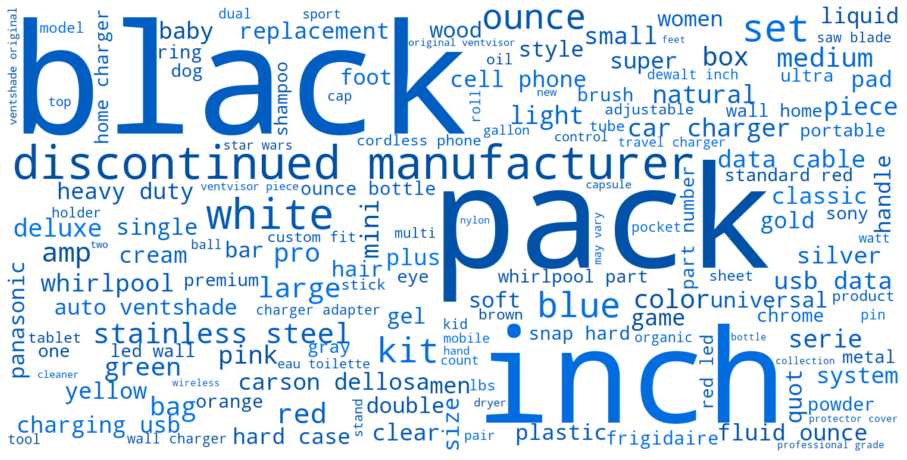

<IPython.core.display.Javascript object>

In [34]:
show_wordcloud(train["clean_title"])

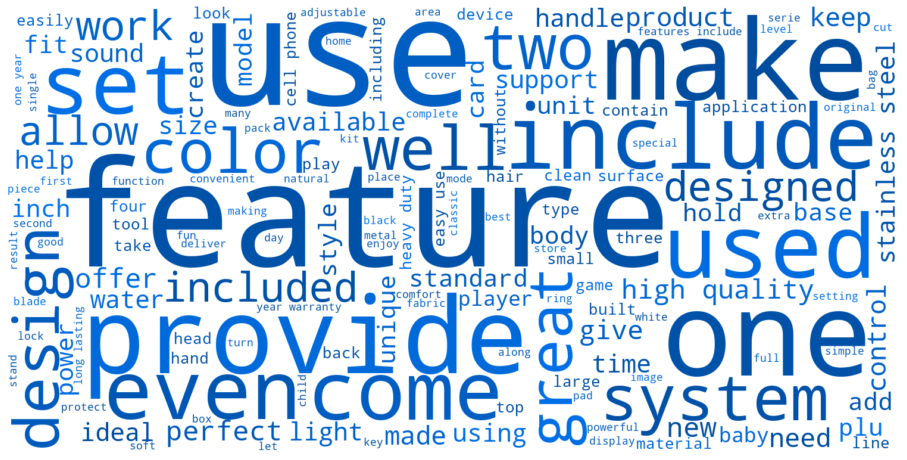

<IPython.core.display.Javascript object>

In [35]:
show_wordcloud(train["clean_description"])

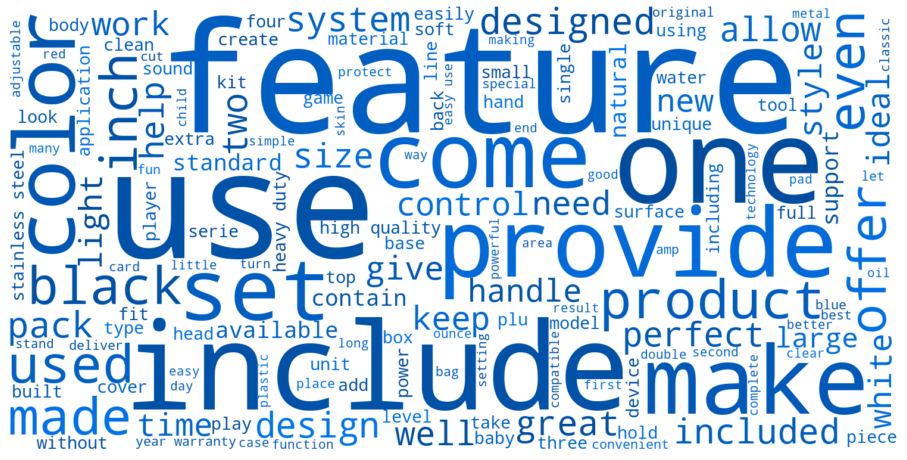

<IPython.core.display.Javascript object>

In [36]:
show_wordcloud(train["clean_title_description"])

We should use `clean_title_description` variable as it already contains all word we need for the further analysis

## Words counts

<AxesSubplot:xlabel='count', ylabel='word'>

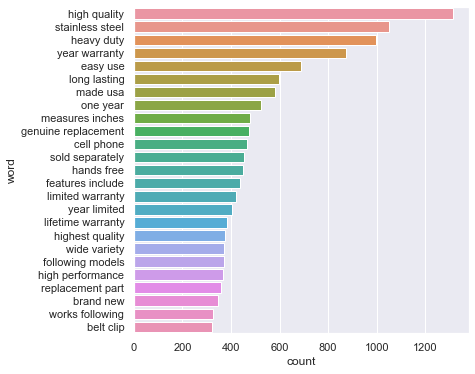

<IPython.core.display.Javascript object>

In [37]:
top_20_bi_titles = get_top_n_words(train["clean_title_description"], 25, 2)
top_20_bi_titles = pd.DataFrame(top_20_bi_titles, columns=["word", "count"])

plt.figure(figsize=(6, 6))
sns.barplot(data=top_20_bi_titles, x="count", y="word")

<AxesSubplot:xlabel='clean_title_description_words', ylabel='categories'>

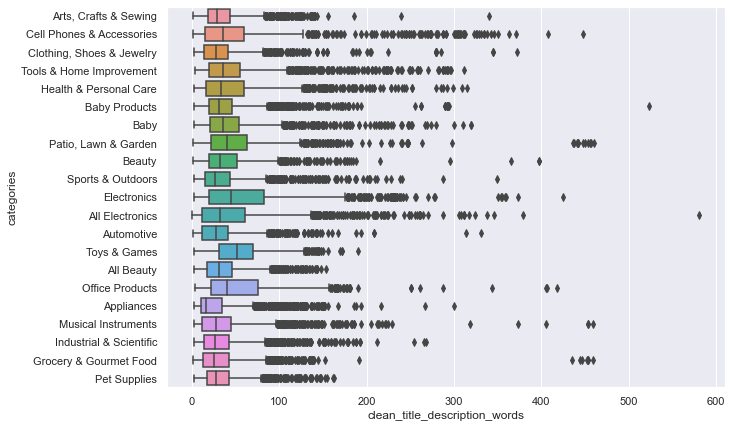

<IPython.core.display.Javascript object>

In [38]:
plt.figure(figsize=(10, 7))
sns.boxplot(y="categories", x="clean_title_description_words", data=train, orient="h")

### 1-grams - Count Vectorizer

In [39]:
def build_plot(word_count_dict):

    col_nums = 3  # how many plots per row
    row_nums = math.ceil(len(word_count_dict) / col_nums)  # how many rows of plots
    plt.figure(figsize=(15, 20))  # change the figure size as needed
    for i, (k, v) in enumerate(word_count_dict.items(), 1):
        plt.subplot(row_nums, col_nums, i)
        p = sns.barplot(data=v, x="count", y="word")
        plt.title(f"Category: {k}")

    plt.tight_layout()

    return plt.show()

<IPython.core.display.Javascript object>

In [40]:
def plot_wordcount(data, var, word_count_function, n, ngrams):
    d = {}
    categories = list(data["categories"].unique())
    for category in categories:
        common_words = get_top_n_words(
            data[var][data["categories"] == category], n, ngrams
        )
        d[category] = pd.DataFrame(common_words, columns=["word", "count"])

    return build_plot(d)

<IPython.core.display.Javascript object>

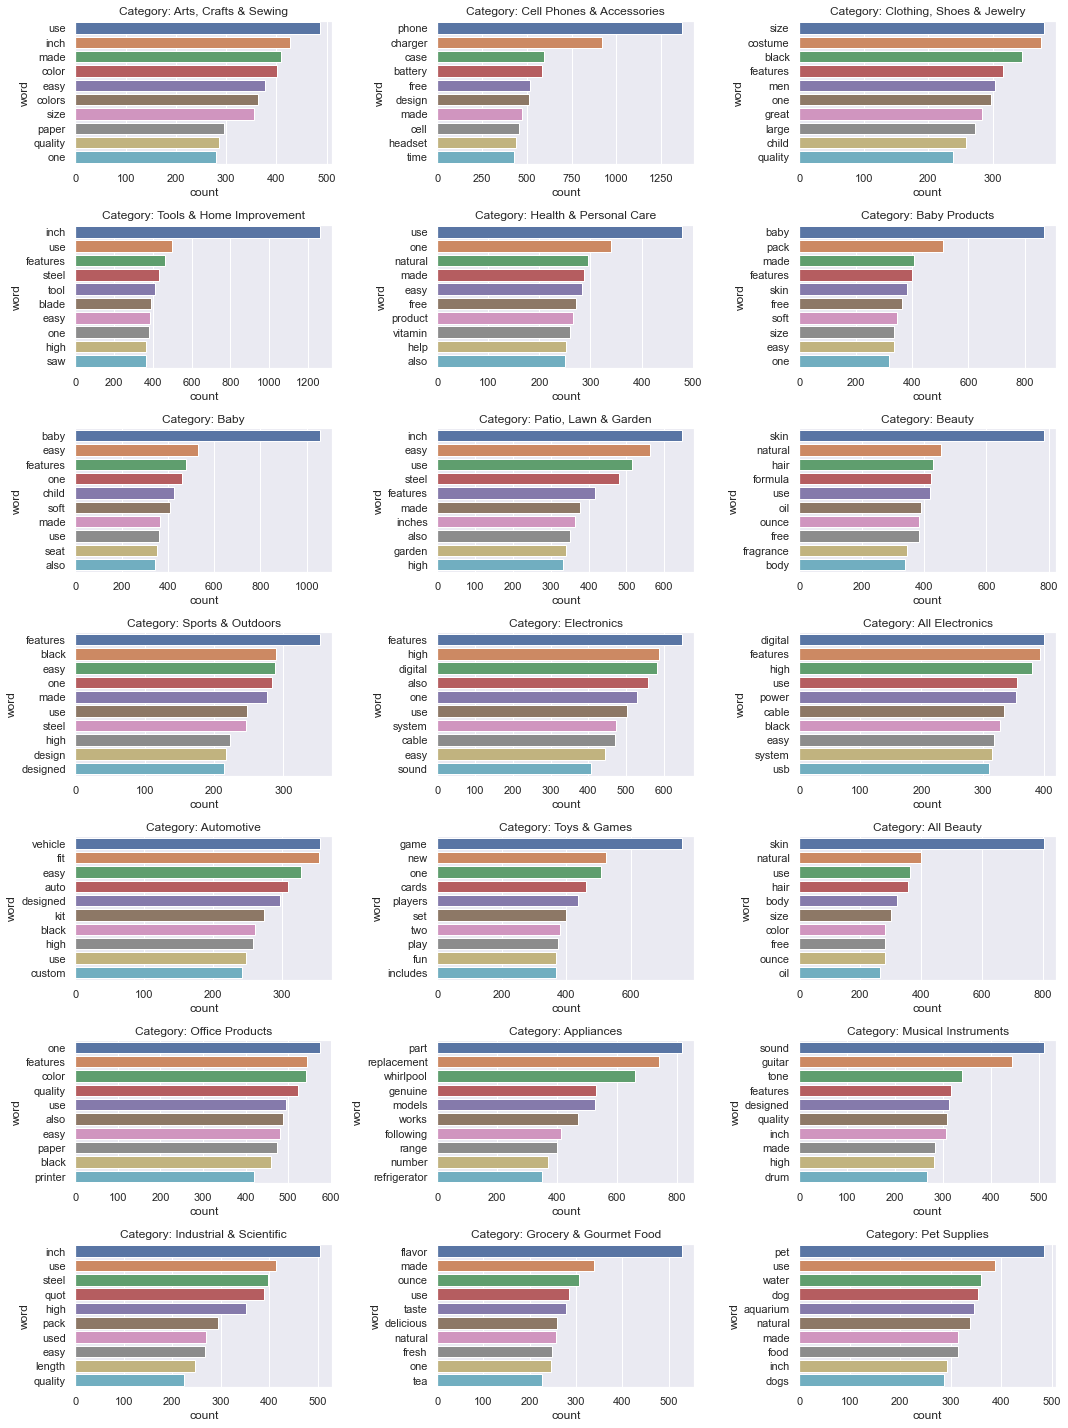

<IPython.core.display.Javascript object>

In [41]:
plot_wordcount(train, "clean_title_description", get_top_n_words, 10, 1)

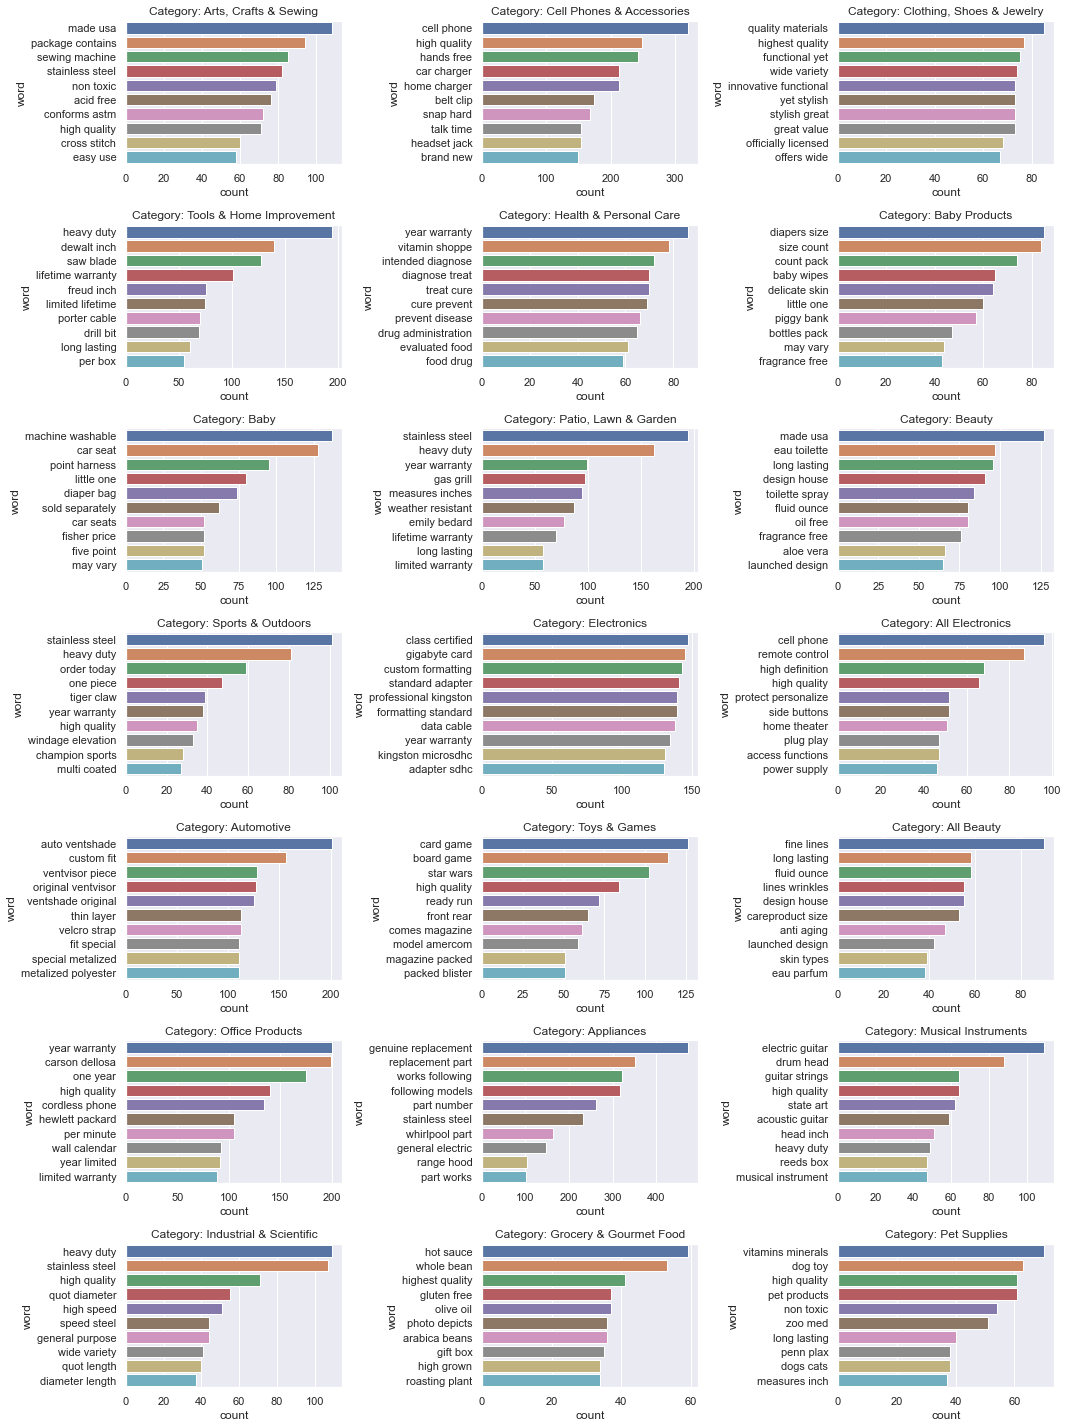

<IPython.core.display.Javascript object>

In [42]:
plot_wordcount(train, "clean_title_description", get_top_n_words, 10, 2)

### 2-grams - Count Vectorizer

In [43]:
def get_top_corr_tfidf(corpus, n=None, ngrams=(1, 1)):
    tfidf = TfidfVectorizer(ngram_range=ngrams)
    features = tfidf.fit_transform(corpus)
    labels = train["category_id"]
    category_id_df = (
        train[["categories", "category_id"]]
        .drop_duplicates()
        .sort_values("category_id")
    )
    category_to_id = dict(category_id_df.values)
    id_to_category = dict(category_id_df[["category_id", "categories"]].values)

    d = {}
    for category, category_id in sorted(category_to_id.items()):
        features_chi2 = chi2(features, labels == category_id)
        indices = np.argsort(features_chi2[0])
        feature_names = np.array(tfidf.get_feature_names())[indices]
        tfidf_feature_corr = list(
            zip(feature_names, features_chi2[0][indices.astype(int)])
        )[-n:]
        data = pd.DataFrame(tfidf_feature_corr, columns=["word", "count"])
        d[category] = data.sort_values(["count"], ascending=False)

    return d

<IPython.core.display.Javascript object>

### 2-grams - TF-IDF

/Users/agnieszka.pochron/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/agnieszka.pochron/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/agnieszka.pochron/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/agnieszka.pochron/opt/anaconda3/lib/python3.8/site-packages/

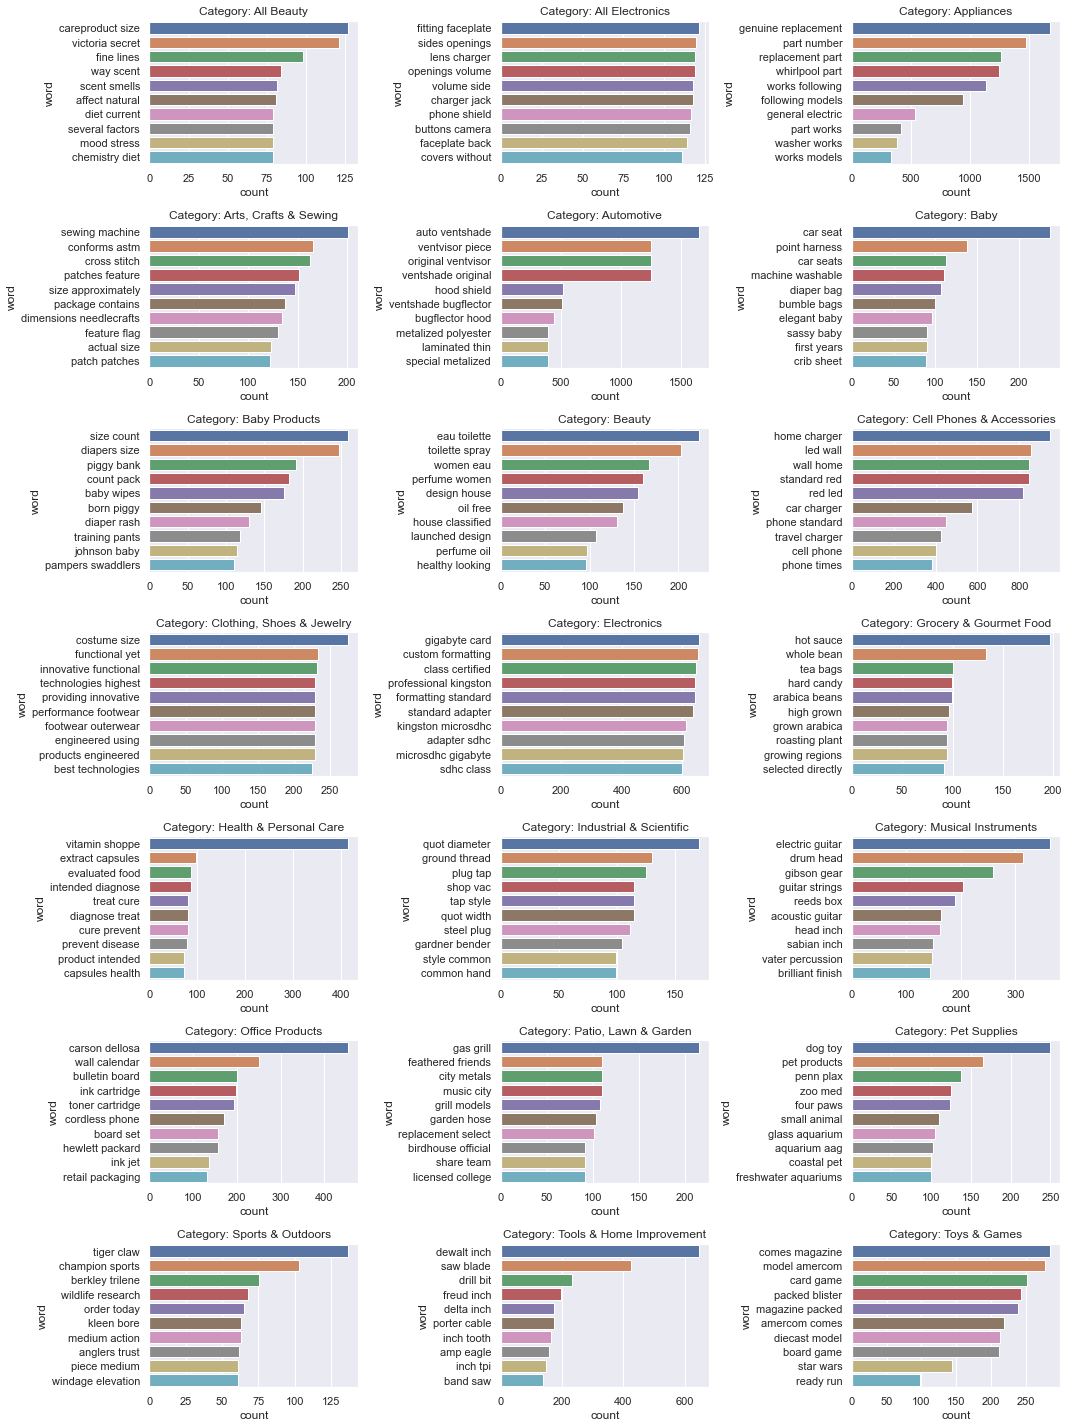

<IPython.core.display.Javascript object>

In [44]:
build_plot(get_top_corr_tfidf(train["clean_title_description"], n=10, ngrams=(2, 2)))

### 3-grams - TF-IDF

/Users/agnieszka.pochron/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/agnieszka.pochron/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/agnieszka.pochron/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/agnieszka.pochron/opt/anaconda3/lib/python3.8/site-packages/

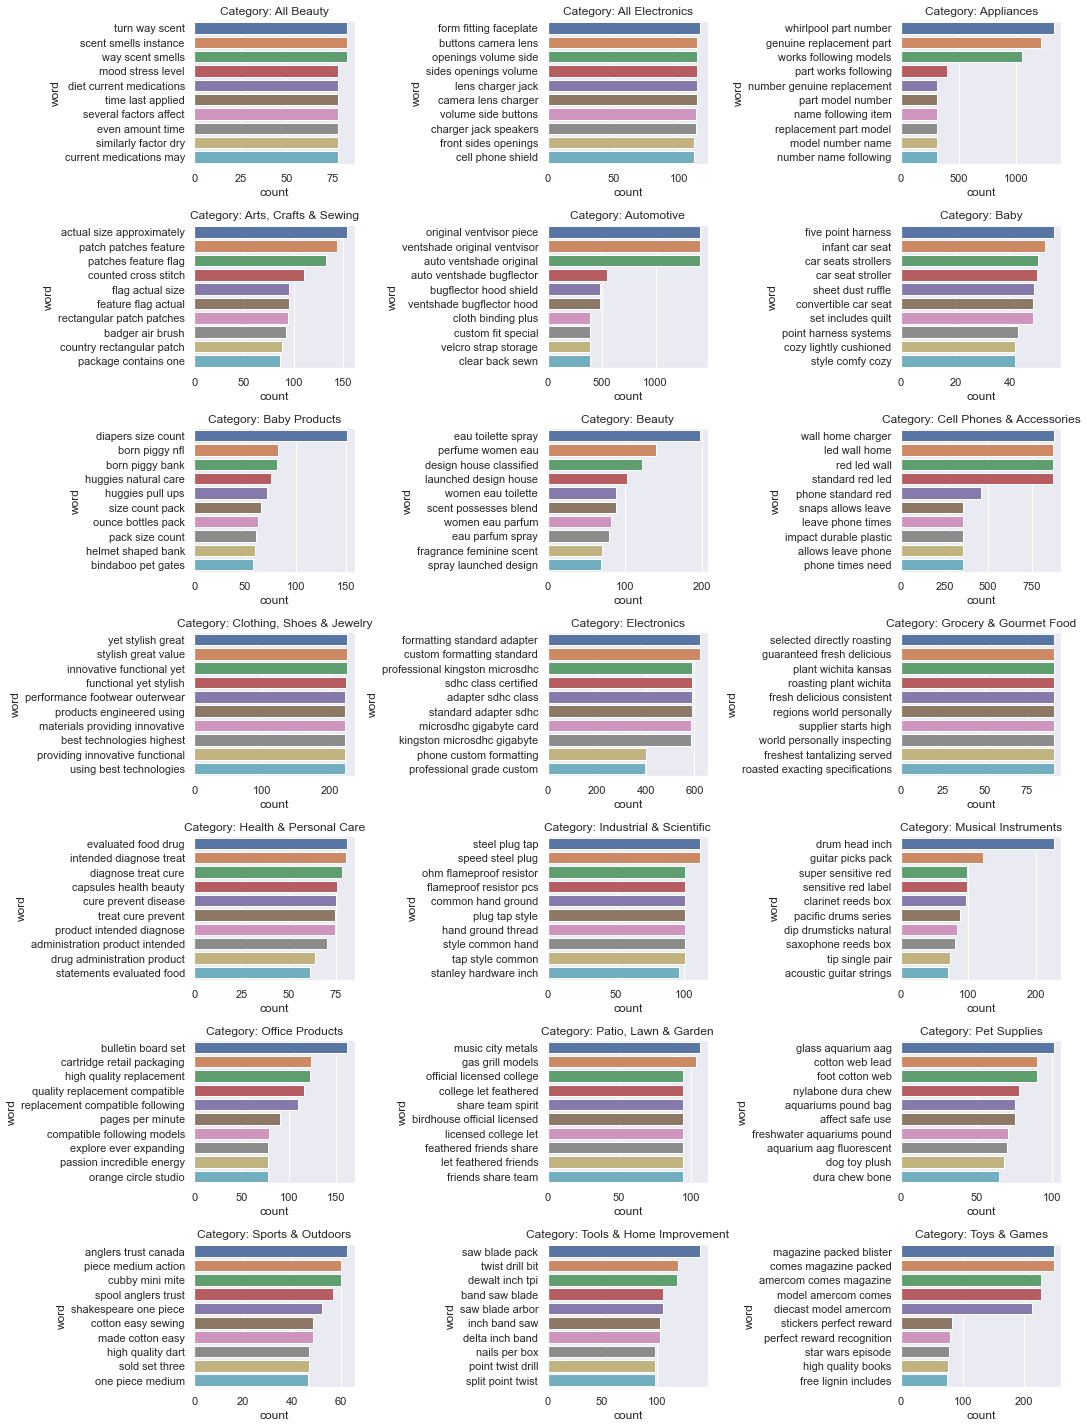

<IPython.core.display.Javascript object>

In [45]:
build_plot(get_top_corr_tfidf(train["clean_title_description"], n=10, ngrams=(3, 3)))

## Correlation between categories

In [46]:
def get_corr_tfidf(corpus, n=None, ngrams=(1, 2)):
    tfidf = TfidfVectorizer(ngram_range=ngrams)
    features = tfidf.fit_transform(corpus)
    labels = train["category_id"]
    category_id_df = (
        train[["categories", "category_id"]]
        .drop_duplicates()
        .sort_values("category_id")
    )
    category_to_id = dict(category_id_df.values)
    id_to_category = dict(category_id_df[["category_id", "categories"]].values)

    d = {}
    for category, category_id in sorted(category_to_id.items()):
        features_chi2 = chi2(features, labels == category_id)
        d[category] = features_chi2[0]

    return d

<IPython.core.display.Javascript object>

In [47]:
dt = get_corr_tfidf(train["clean_title_description"], n=None, ngrams=(1, 2))
dt = pd.DataFrame.from_dict(dt)

<IPython.core.display.Javascript object>

/var/folders/_0/mfk40yqs54g8qmxdycyx0m2m0000gp/T/ipykernel_31462/4263819428.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cax)


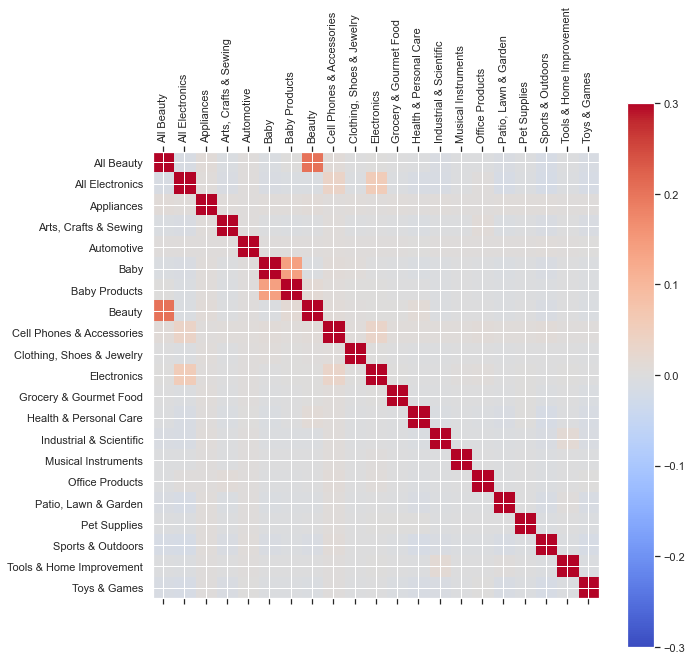

<IPython.core.display.Javascript object>

In [48]:
# Correlation between classes - very low, classes are well seprated

sns.set(rc={"figure.figsize": (10, 10)})

corr = dt.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr, cmap="coolwarm", vmin=-0.3, vmax=0.3)
fig.colorbar(cax)
ticks = np.arange(0, len(dt.columns), 1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(dt.columns)
ax.set_yticklabels(dt.columns)
plt.show()

## Embeddings

In [49]:
train_1 = train.reset_index(drop=True)
size = train_1["categories"].nunique()
encoder = LabelEncoder()
aut = encoder.fit_transform(train_1["categories"])

<IPython.core.display.Javascript object>

In [50]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2))
X_train_vect = tfidf_vect.fit_transform(train_1["clean_title_description"])
X_train_vect.shape

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_trans = TfidfTransformer()
X_train_tfidf = tfidf_trans.fit_transform(X_train_vect)
rat = X_train_tfidf.data

<IPython.core.display.Javascript object>

In [51]:
class Latent_Embed(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Latent_Embed, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(3, 2)
        self.linear2 = nn.Linear(2, 1)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        out = F.relu(self.linear1(embeds))
        out = F.relu(self.linear2(out))
        return out


aut_t = torch.tensor(aut)
rat_t = torch.tensor(rat)
loss_function = nn.MSELoss()
model = Latent_Embed(size, 3)
optimizer = optim.SGD(model.parameters(), lr=0.0001)

for epoch in range(10):
    total_loss = 0
    for context, target in zip(aut_t, rat_t):
        model.zero_grad()
        log_probs = model(context)
        loss = loss_function(log_probs.double(), target.view(1).double())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print("Loss: ", total_loss / len(aut_t))

Loss:  0.010620560990703994
Loss:  0.004448454066707925
Loss:  0.004158919590477558
Loss:  0.0041517676697670185
Loss:  0.004151496193627306
Loss:  0.004151502468718707
Loss:  0.004151508898841492
Loss:  0.004151509948110418
Loss:  0.0041515107573571715
Loss:  0.004151511147923948


<IPython.core.display.Javascript object>

In [52]:
embedding_weights = pd.DataFrame(model.embeddings.weight.detach().numpy())
embedding_weights.columns = ["X1", "X2", "X3"]
embedding_weights

X1        X2        X3
0   1.259184 -0.725309 -0.177992
1  -0.281293 -0.406859  1.223541
2   0.129690 -0.399083  2.800759
3  -0.176423  0.874238 -0.715577
4  -1.203489 -0.593289  1.331348
5  -1.550740  0.471652  1.332694
6   1.587169 -0.771026 -0.953390
7   0.403194  0.128465 -1.812956
8  -1.632791 -0.862868 -1.577703
9  -0.421812 -1.339618  0.543523
10 -1.238758 -1.007469 -1.277241
11  1.476686 -0.825878 -1.819444
12 -0.950594 -0.610505  0.394849
13 -1.250242  0.182872 -0.785048
14 -1.373742 -0.302692  0.395612
15 -0.160634  0.796896 -1.320052
16 -0.806368  0.371483 -1.451756
17 -1.564755 -0.972252 -0.137855
18 -0.719217 -0.618990 -0.401921
19 -1.456487  0.474670  1.194870
20  0.095678  1.227480 -1.598453

<IPython.core.display.Javascript object>

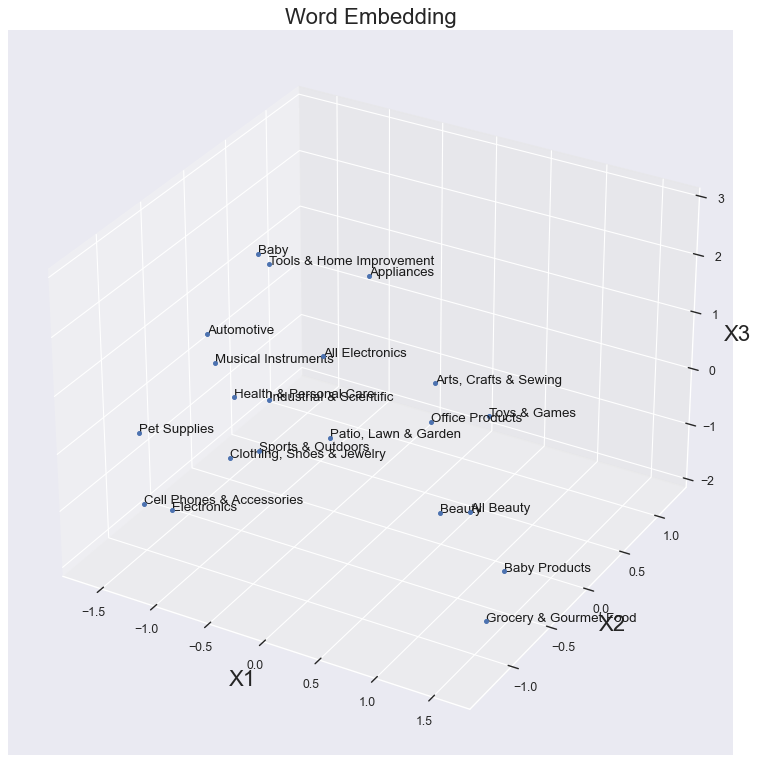

<IPython.core.display.Javascript object>

In [53]:
fig = plt.figure(num=None, figsize=(14, 12), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection='3d')
for index, (x, y, z) in enumerate(zip(embedding_weights['X1'], 
                                      embedding_weights['X2'], 
                                      embedding_weights['X3'])):
    ax.scatter(x, y, z, color='b', s=12)
    ax.text(x, y, z, str(encoder.inverse_transform([index]))[2:-2], size=12, zorder=2.5, color='k')

ax.set_title("Word Embedding", fontsize=20)
ax.set_xlabel("X1", fontsize=20)
ax.set_ylabel("X2", fontsize=20)
ax.set_zlabel("X3", fontsize=20)
plt.show()


## Classes separation

In [108]:
from yellowbrick.text.tsne import tsne

<IPython.core.display.Javascript object>

In [109]:
train["categories"].unique()

array(['Arts, Crafts & Sewing', 'Cell Phones & Accessories',
       'Clothing, Shoes & Jewelry', 'Tools & Home Improvement',
       'Health & Personal Care', 'Baby Products', 'Baby',
       'Patio, Lawn & Garden', 'Beauty', 'Sports & Outdoors',
       'Electronics', 'All Electronics', 'Automotive', 'Toys & Games',
       'All Beauty', 'Office Products', 'Appliances',
       'Musical Instruments', 'Industrial & Scientific',
       'Grocery & Gourmet Food', 'Pet Supplies'], dtype=object)

<IPython.core.display.Javascript object>

In [110]:
cat1 = [
    "Arts, Crafts & Sewing",
    "Cell Phones & Accessories",
    "Clothing, Shoes & Jewelry",
    "Tools & Home Improvement",
    "Health & Personal Care",
    "Baby Products",
]
cat2 = [
    "Baby",
    "Patio, Lawn & Garden",
    "Beauty",
    "Sports & Outdoors",
    "Electronics",
]
cat3 = [
    "Automotive",
    "Toys & Games",
    "All Beauty",
    "Office Products",
    "Appliances",
]
cat4 = [
    "All Electronics",
    "Musical Instruments",
    "Industrial & Scientific",
    "Grocery & Gourmet Food",
    "Pet Supplies",
]

<IPython.core.display.Javascript object>

In [111]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2))

<IPython.core.display.Javascript object>

In [112]:
X1 = tfidf_vect.fit_transform(
    train["clean_title_description"][train["categories"].isin(cat1)]
)
y1 = train["categories"][train["categories"].isin(cat1)]

X2 = tfidf_vect.fit_transform(
    train["clean_title_description"][train["categories"].isin(cat2)]
)
y2 = train["categories"][train["categories"].isin(cat2)]

X3 = tfidf_vect.fit_transform(
    train["clean_title_description"][train["categories"].isin(cat3)]
)
y3 = train["categories"][train["categories"].isin(cat3)]

X4 = tfidf_vect.fit_transform(
    train["clean_title_description"][train["categories"].isin(cat4)]
)
y4 = train["categories"][train["categories"].isin(cat4)]

<IPython.core.display.Javascript object>

/Users/agnieszka.pochron/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/agnieszka.pochron/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to sp

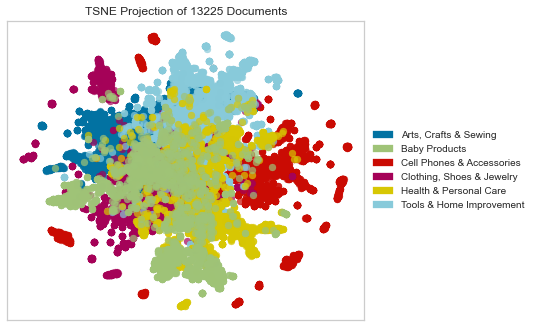

AttributeError: 'TSNEVisualizer' object has no attribute 'classes'

AttributeError: 'TSNEVisualizer' object has no attribute 'classes'

<IPython.core.display.Javascript object>

In [122]:
tsne(X1, y1)

/Users/agnieszka.pochron/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/agnieszka.pochron/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to sp

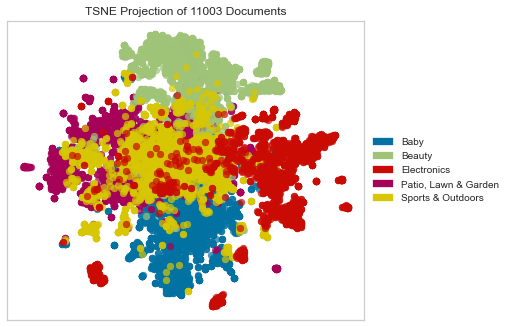

AttributeError: 'TSNEVisualizer' object has no attribute 'classes'

AttributeError: 'TSNEVisualizer' object has no attribute 'classes'

<IPython.core.display.Javascript object>

In [119]:
from yellowbrick.text.tsne import tsne

tsne(X2, y2)

/Users/agnieszka.pochron/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/agnieszka.pochron/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to sp

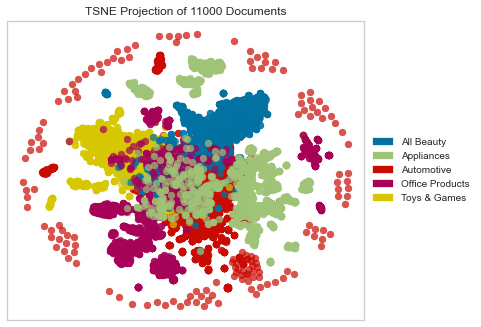

AttributeError: 'TSNEVisualizer' object has no attribute 'classes'

AttributeError: 'TSNEVisualizer' object has no attribute 'classes'

<IPython.core.display.Javascript object>

In [115]:
tsne(X3, y3)

/Users/agnieszka.pochron/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/agnieszka.pochron/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to sp

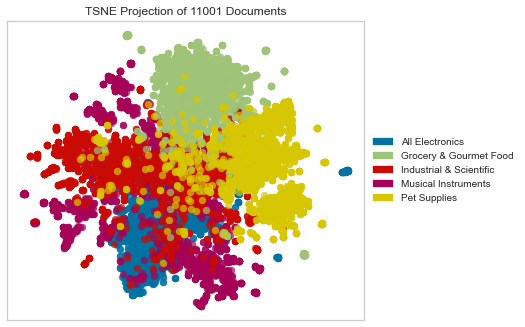

AttributeError: 'TSNEVisualizer' object has no attribute 'classes'

AttributeError: 'TSNEVisualizer' object has no attribute 'classes'

<IPython.core.display.Javascript object>

In [116]:
tsne(X4, y4)